In [1]:
from temporal_networkx import TemporalDiGraph
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import seaborn as sb
from datetime import datetime, timedelta
from copy import deepcopy

In [2]:
temporal_graph = TemporalDiGraph(pd.read_csv('./soc-sign-bitcoinotc.csv', header=None))

In [3]:
help(TemporalDiGraph)

Help on class TemporalDiGraph in module temporal_networkx.temporal_networkx:

class TemporalDiGraph(builtins.object)
 |  TemporalDiGraph(df)
 |  
 |  Class to process the dataset of the trust network on BitcoinOTC marketplace.
 |  
 |  Includes REV2 algorithm from https://github.com/horizonly/Rev2-model
 |  @inproceedings{kumar2018rev2, title={Rev2: Fraudulent user prediction in rating platforms},
 |  author={Kumar, Srijan and Hooi, Bryan and Makhija, Disha and Kumar, Mohit and Faloutsos, Christos and Subrahmanian, VS},
 |  booktitle={Proceedings of the Eleventh ACM International Conference on Web Search and Data Mining},
 |  pages={333--341}, year={2018}, 321、 organization={ACM} }
 |  ...
 |  Attributes
 |  ----------
 |  df : pandas.DataFrame
 |      (Read-only) A DataFrame created from the dataset.
 |      
 |  simulation : pandas.DataFrame
 |      (Read-only) A duplicate of the DataFrame df. Used during simulation.
 |  
 |  baseline_graph : networkx.MultiDiGraph
 |      (Read-only)

In [44]:
baseline_graph = deepcopy(temporal_graph.baseline_graph)

In [45]:
nx.write_gpickle(baseline_graph, 'baseline_graph.gpickle')

# Simulation of Banning Users

## Preparation of Methods

First, a snapshot of the directed graph for the whole dataset is generated when the class is instantiated for comparison during simulation.

### Banning a Single User

The parameters of the method are:
* node_id (int) - Node ID of the user in the dataset.
* ban_month (str) - Month when the user is banned (after the month has ended), in YYYY-MM format.
* rating_threshold (float) - Any rating below this threshold would be considered as a bad rating. Defaults to 0.0.
* fairness_threshold (float) - Any edge fairness below this threshold would be considered as a biased rating. Defaults to 0.0.
* verbose (bool) - Whether the simulation is run verbosely.

The method returns a dictionary with the following information:
* Final goodness score of the user
* Final average rating of the user
* Rating, fairness and count of the in-edges and out-edges of the user in the future

Unit test of the method:

In [4]:
result = temporal_graph.ban_user(103, '2011-05', 0.0, 0.0, True)

At end of the baseline dataset, the 103 had a final average rating of 1.0, and final goodness score of 0.6346669696017236.
Banning the user would have prevent 0 bad in-edges (0 fair, 0 biased) and 0 good in-edges (0 fair, 0 biased),
and 0 bad out-edges (0 fair, 0 biased) and 0 good out-edges (0 fair, 0 biased).


In [5]:
result = temporal_graph.ban_user(179, '2011-05', 0.0, 0.0, True)

At end of the baseline dataset, the 179 had a final average rating of -0.42857142857142855, and final goodness score of -0.11512300644992719.
Banning the user would have prevent 0 bad in-edges (0 fair, 0 biased) and 0 good in-edges (0 fair, 0 biased),
and 0 bad out-edges (0 fair, 0 biased) and 0 good out-edges (0 fair, 0 biased).


### Banning Bad Users at the End of Each Month

After defining the method to simulate the effect of banning one user, the following method finds out bad users at the end of each month of the dataset, and simulates the effects of banning the bad users.

The parameters of this method are:
* criterion (str): Can be 'goodness' meaning to REV2 goodness score to find out bad users, or 'average' or 'average_rating' meaning to use average rating to find out bad users.
* threshold (float): Users having goodness score OR average rating below this threshold would be considered as bad users, and simulation would run on these users.
* verbose (bool): Whether this method should be run verbosely.
* verbose_ban_user (bool): Whether the simulation of banning individual users should be run verbosely. Default to False.

The method would return the following pd.DataFrame objects:
* users_banned_average_df - The final goodness score and average rating of the users being banned.
* in_edges_removed_df - Rating and fairness of the in-edges that would have been prevented as a result of users being banned.
* out_edges_removed_df- Rating and fairness of the out-edges that would have been prevented as a result of users being banned.

## Simulations

### Simulation Using Average Ratings

In [3]:
users_banned_average, in_edges_removed_average, out_edges_removed_average = temporal_graph.simulation('average', 0, True)

Running simulation of banning users based on average_rating with threshold of 0
---------------------------------------------------------------------------
Simulating for the month 2010-11
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2010-12
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-01
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-02
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have 

The directed graph generated in simulation is pickled so it can be used for analysis later.

In [5]:
simulation_graph_average = deepcopy(temporal_graph.get_DiGraph(run_REV2=True, calc_average=True, use_simulation_data=True))

In [14]:
nx.write_gpickle(simulation_graph_average, 'simulation_graph_average.gpickle')

### Simulation Using Goodness Scores

In [15]:
users_banned_goodness, in_edges_removed_goodness, out_edges_removed_goodness = temporal_graph.simulation('goodness', 0, True)

Running simulation of banning users based on goodness with threshold of 0
---------------------------------------------------------------------------
Simulating for the month 2010-11
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2010-12
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-01
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affected the future
---------------------------------------------------------------------------
Simulating for the month 2011-02
Effects of banning users in this month:
0 bad user(s) were banned
Simulation of this month would not have affect

The directed graph generated in simulation is pickled so it can be used for analysis later.

In [16]:
simulation_graph_goodness = deepcopy(temporal_graph.get_DiGraph(run_REV2=True, calc_average=True, use_simulation_data=True))

In [18]:
nx.write_gpickle(simulation_graph_goodness, 'simulation_graph_goodness.gpickle')

## Results

In [26]:
sb.set_style('darkgrid')

In [203]:
users_banned_average.to_csv('users_banned_average.csv')
in_edges_removed_average.to_csv('in_edges_removed_average.csv')
out_edges_removed_average.to_csv('out_edges_removed_average.csv')

In [204]:
users_banned_goodness.to_csv('users_banned_goodness.csv')
in_edges_removed_goodness.to_csv('in_edges_removed_goodness.csv')
out_edges_removed_goodness.to_csv('out_edges_removed_goodness.csv')

In [3]:
users_banned_average = pd.read_csv('users_banned_average.csv')
in_edges_removed_average = pd.read_csv('in_edges_removed_average.csv')
out_edges_removed_average = pd.read_csv('out_edges_removed_average.csv')
users_banned_goodness = pd.read_csv('users_banned_goodness.csv')
in_edges_removed_goodness = pd.read_csv('in_edges_removed_goodness.csv')
out_edges_removed_goodness = pd.read_csv('out_edges_removed_goodness.csv')

First, the new columns are added to ```users_banned_goodness``` and ```users_banned_average``` to indicate whether the users had a final score/average rating below or above threshold.

In [39]:
users_banned_goodness['User type by Average'] = users_banned_goodness.apply(lambda row:
    'Flagged' if row['final_average_rating'] < 0 else 'Normal',
    axis=1
)
users_banned_goodness['User type by Goodness'] = users_banned_goodness.apply(lambda row:
    'Flagged' if row['final_goodness'] < 0 else 'Normal',
    axis=1
)

In [40]:
users_banned_average['User type by Average'] = users_banned_average.apply(lambda row:
    'Flagged' if row['final_average_rating'] < 0 else 'Normal',
    axis=1
)
users_banned_average['User type by Goodness'] = users_banned_average.apply(lambda row:
    'Flagged' if row['final_goodness'] < 0 else 'Normal',
    axis=1
)

### Final Goodness Scores of the Users 

In [24]:
title_size = 24
xy_label_size = 22
xy_ticks_size = 16
annotation_size =18

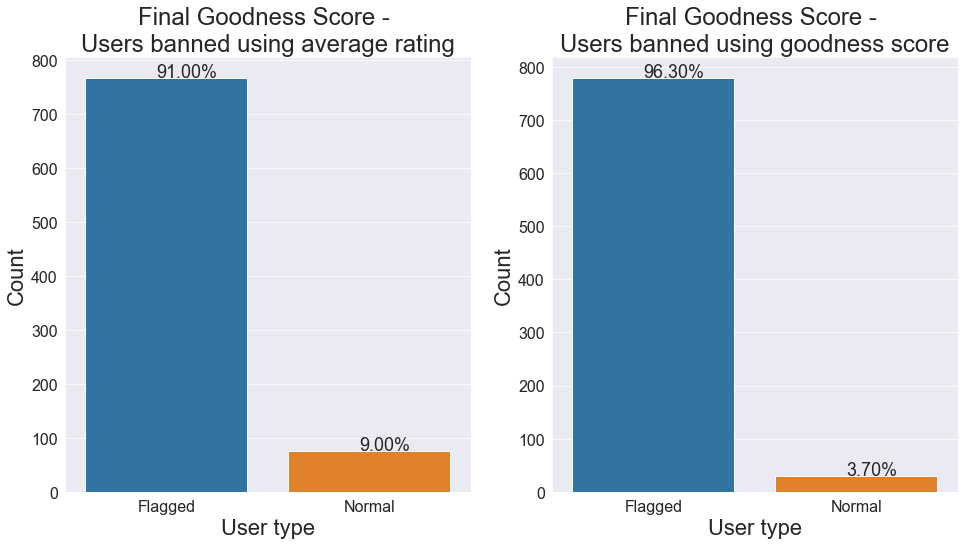

In [41]:
plt.figure(figsize=(16, 8))

num_bad = (len(users_banned_average[users_banned_average['User type by Goodness'] == 'Flagged']) / len(users_banned_average['User type by Goodness']))*100
num_good = (len(users_banned_average[users_banned_average['User type by Goodness'] == 'Normal']) / len(users_banned_average['User type by Goodness']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(121)
ax = sb.countplot(data=users_banned_average,
                  x='User type by Goodness',
                  order=users_banned_average['User type by Goodness'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.5), fontsize=annotation_size)

plt.title('Final Goodness Score - \nUsers banned using average rating', fontsize=title_size)
plt.xlabel('User type', fontsize=xy_label_size)
plt.ylabel('Count', fontsize=xy_label_size)
plt.xticks(fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)

num_bad = (len(users_banned_goodness[users_banned_goodness['User type by Goodness'] == 'Flagged']) / len(users_banned_goodness['User type by Goodness']))*100
num_good = (len(users_banned_goodness[users_banned_goodness['User type by Goodness'] == 'Normal']) / len(users_banned_goodness['User type by Goodness']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(122)
ax = sb.countplot(data=users_banned_goodness,
                  x='User type by Goodness',
                  order=users_banned_goodness['User type by Goodness'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.5), fontsize=annotation_size)

plt.title('Final Goodness Score - \nUsers banned using goodness score', fontsize=title_size)
plt.xlabel('User type', fontsize=xy_label_size)
plt.ylabel('Count', fontsize=xy_label_size)
plt.xticks(fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)
plt.show()

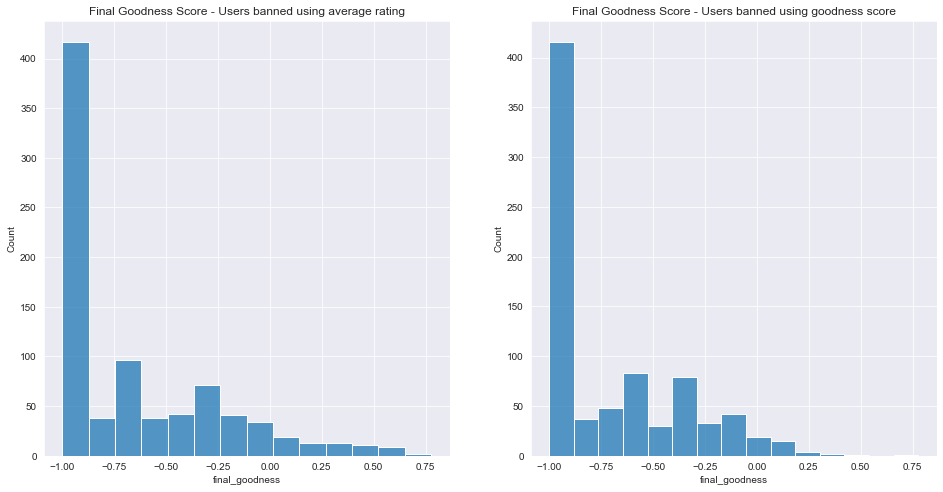

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=users_banned_average,x='final_goodness')
plt.title('Final Goodness Score - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=users_banned_goodness, x='final_goodness')
plt.title('Final Goodness Score - Users banned using goodness score')
plt.show()

### Final Average Ratings of the Users

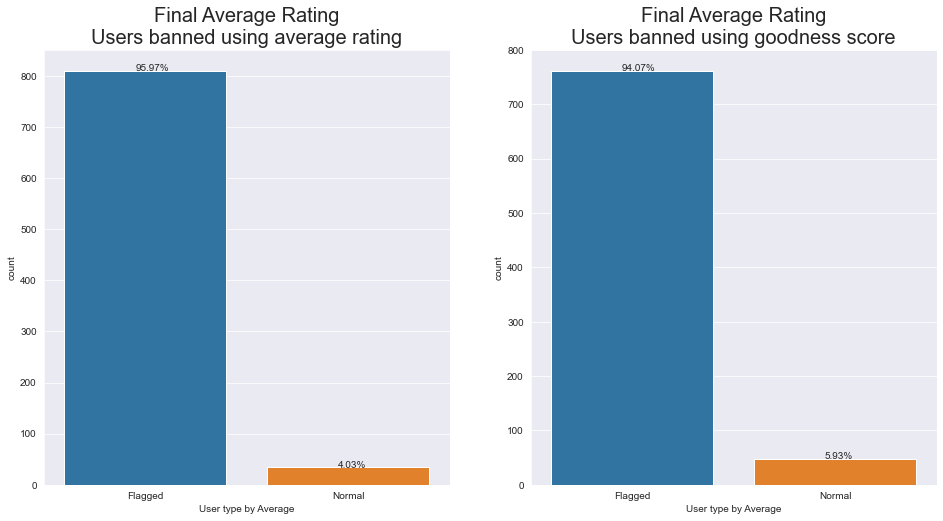

In [43]:
plt.figure(figsize=(16, 8))

num_bad = (len(users_banned_average[users_banned_average['User type by Average'] == 'Flagged']) / len(users_banned_average['User type by Average']))*100
num_good = (len(users_banned_average[users_banned_average['User type by Average'] == 'Normal']) / len(users_banned_average['User type by Average']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(121)
ax = sb.countplot(data=users_banned_average,
                  x='User type by Average',
                  order=users_banned_average['User type by Average'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.2))

plt.title('Final Average Rating\nUsers banned using average rating', fontsize=20)


num_bad = (len(users_banned_goodness[users_banned_goodness['User type by Average'] == 'Flagged']) / len(users_banned_goodness['User type by Average']))*100
num_good = (len(users_banned_goodness[users_banned_goodness['User type by Average'] == 'Normal']) / len(users_banned_goodness['User type by Average']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(122)
ax = sb.countplot(data=users_banned_goodness,
                  x='User type by Average',
                  order=users_banned_goodness['User type by Average'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.2))

plt.title('Final Average Rating\nUsers banned using goodness score', fontsize=20)
plt.show()

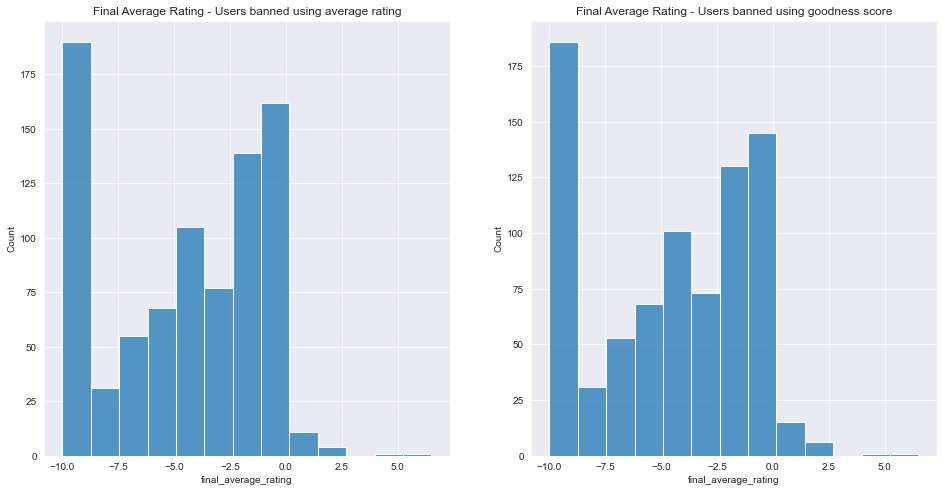

In [15]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=users_banned_average, x='final_average_rating')
plt.title('Final Average Rating - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=users_banned_goodness, x='final_average_rating')
plt.title('Final Average Rating - Users banned using goodness score')
plt.show()

### Ratings of the In-Edges Removed

In [20]:
in_edges_removed_average['Edge Type'] = in_edges_removed_average.apply(lambda row:
    'Distrust' if row['rating'] < 0 else 'Trust',
    axis=1
)
in_edges_removed_goodness['Edge Type'] = in_edges_removed_goodness.apply(lambda row:
    'Distrust' if row['rating'] < 0 else 'Trust',
    axis=1
)


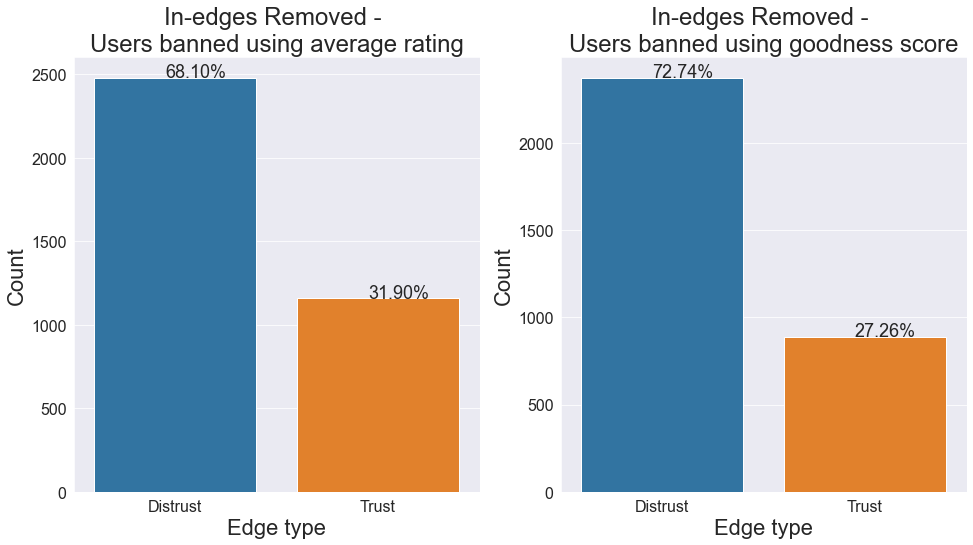

In [27]:
plt.figure(figsize=(16, 8))

num_bad = (len(in_edges_removed_average[in_edges_removed_average['Edge Type'] == 'Distrust']) / len(in_edges_removed_average['Edge Type']))*100
num_good = (len(in_edges_removed_average[in_edges_removed_average['Edge Type'] == 'Trust']) / len(in_edges_removed_average['Edge Type']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(121)
ax = sb.countplot(data=in_edges_removed_average,
                  x='Edge Type',
                  order=in_edges_removed_average['Edge Type'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.5), fontsize=annotation_size)

plt.title('In-edges Removed - \nUsers banned using average rating', fontsize=title_size)
plt.xlabel('Edge type', fontsize=xy_label_size)
plt.ylabel('Count', fontsize=xy_label_size)
plt.xticks(fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)

num_bad = (len(in_edges_removed_goodness[in_edges_removed_goodness['Edge Type'] == 'Distrust']) / len(in_edges_removed_goodness['Edge Type']))*100
num_good = (len(in_edges_removed_goodness[in_edges_removed_goodness['Edge Type'] == 'Trust']) / len(in_edges_removed_goodness['Edge Type']))*100
pct_bad = '{:.2f}%'.format(num_bad)
pct_good = '{:.2f}%'.format(num_good)

col_labels = [pct_bad, pct_good]
plt.subplot(122)
ax = sb.countplot(data=in_edges_removed_goodness,
                  x='Edge Type',
                  order=in_edges_removed_goodness['Edge Type'].value_counts().index)

for p, label in zip(ax.patches, col_labels):
     ax.annotate(label, (p.get_x()+0.35, p.get_height()+0.5), fontsize=annotation_size)

plt.title('In-edges Removed - \nUsers banned using goodness score', fontsize=title_size)
plt.xlabel('Edge type', fontsize=xy_label_size)
plt.ylabel('Count', fontsize=xy_label_size)
plt.xticks(fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)
plt.show()

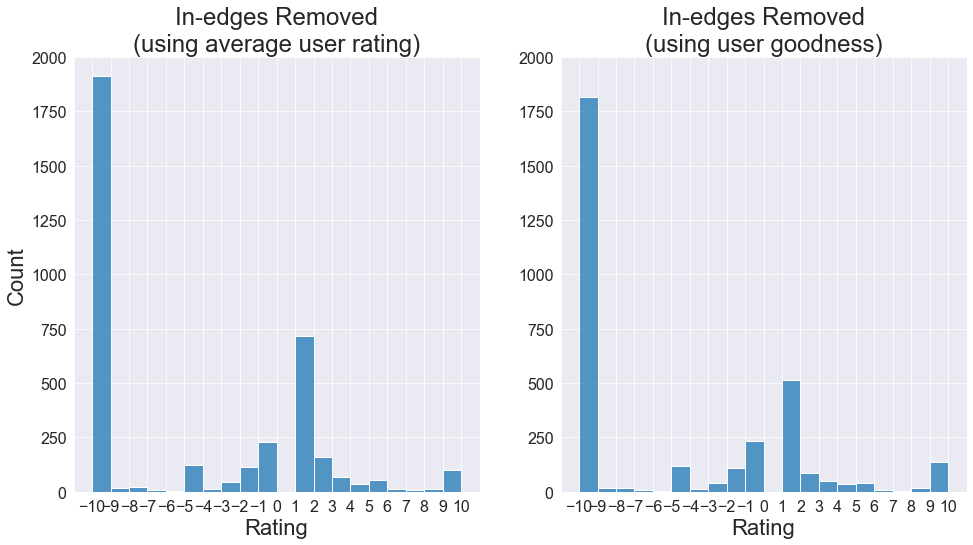

In [129]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=in_edges_removed_average, x='rating', binwidth=1)
plt.title('In-edges Removed\n(using average user rating)', fontsize=title_size)
plt.xlabel('Rating', fontsize=xy_label_size)
plt.xticks(sorted(list(in_edges_removed_average['rating'].unique()) + [0.0]), fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)
plt.ylabel('Count', fontsize=xy_label_size)
plt.ylim(0,2000)

plt.subplot(122)
sb.histplot(data=in_edges_removed_goodness, x='rating', binwidth=1)
plt.title('In-edges Removed\n(using user goodness)', fontsize=title_size)
plt.xlabel('Rating', fontsize=xy_label_size)
plt.xticks(sorted(list(in_edges_removed_goodness['rating'].unique()) + [0.0]), fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)
plt.ylabel('')
plt.ylim(0,2000)
plt.show()

### Ratings of Out-Edges Removed

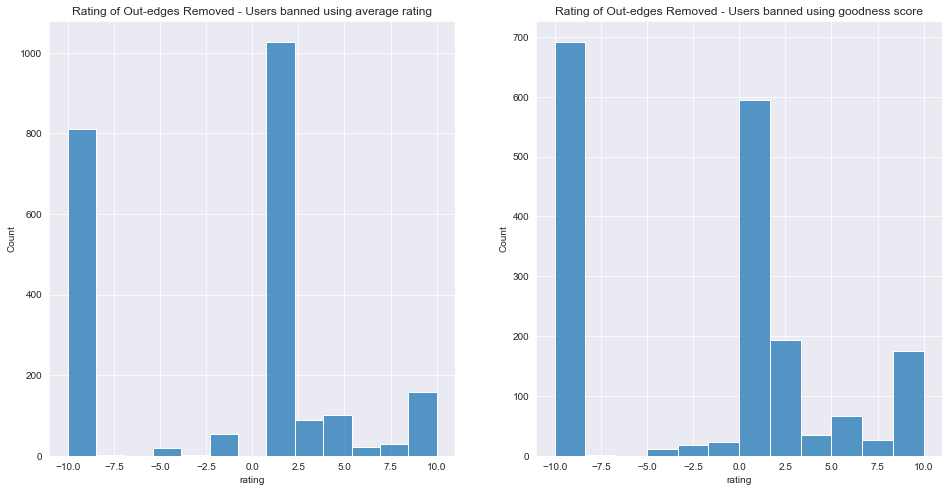

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sb.histplot(data=out_edges_removed_average, x='rating')
plt.title('Rating of Out-edges Removed - Users banned using average rating')
plt.subplot(122)
sb.histplot(data=out_edges_removed_goodness, x='rating')
plt.title('Rating of Out-edges Removed - Users banned using goodness score')
plt.show()

In [72]:
users_banned_average[(users_banned_average['User type by Goodness'] == 'Normal')]

,month,node_id,final_goodness,final_average_rating,User type,User type by Average,User type by Goodness
11,2011-06,423,0.300507,-0.285714,Normal,Flagged,Normal
12,2011-06,566,0.020813,-0.222222,Normal,Flagged,Normal
15,2011-06,804,0.561376,-0.666667,Normal,Flagged,Normal
21,2011-06,958,0.562706,-0.500000,Normal,Flagged,Normal
29,2011-06,1277,0.012465,0.090909,Normal,Normal,Normal
...,...,...,...,...,...,...,...
778,2014-07,5631,0.583830,-1.200000,Normal,Flagged,Normal
782,2014-08,1154,0.004180,-0.117647,Normal,Flagged,Normal
787,2014-08,5556,0.309388,-2.666667,Normal,Flagged,Normal
823,2015-01,5846,0.151650,0.000000,Normal,Normal,Normal


In [71]:
users_banned_goodness[(users_banned_goodness['User type by Goodness'] == 'Normal')]

,month,node_id,final_goodness,final_average_rating,type_rating,type_goodness,User type,User type by Goodness,User type by Average
27,2011-06,1277,0.012465,0.090909,good,good,Normal,Normal,Normal
51,2012-04,1660,0.037780,0.000000,good,good,Normal,Normal,Normal
69,2012-07,61,0.020333,-0.555556,bad,good,Normal,Normal,Flagged
76,2012-07,2252,0.777297,1.518519,good,good,Normal,Normal,Normal
85,2012-08,2370,0.437564,1.800000,good,good,Normal,Normal,Normal
87,2012-08,2435,0.091180,0.000000,good,good,Normal,Normal,Normal
147,2012-09,2648,0.010956,-1.000000,bad,good,Normal,Normal,Flagged
211,2012-11,2766,0.175850,-4.500000,bad,good,Normal,Normal,Flagged
219,2012-11,2929,0.194032,0.400000,good,good,Normal,Normal,Normal
222,2012-11,3003,0.380860,0.714286,good,good,Normal,Normal,Normal


In [83]:
ratings = []
for e in baseline_graph.in_edges(data=True):
    ratings.append(e[2]['weight'])

In [84]:
positive_ratings = [ x for x in ratings if x > 0]
negative_ratings = [ x for x in ratings if x < 0]

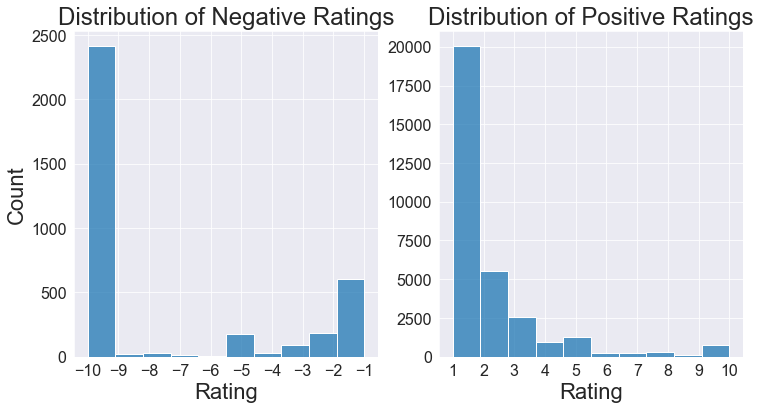

In [109]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sb.histplot(data=negative_ratings, bins=10)
plt.title('Distribution of Negative Ratings', fontsize=title_size)
plt.xticks(list(set(negative_ratings)), fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)
plt.xlabel('Rating', fontsize=xy_label_size)
plt.ylabel('Count', fontsize=xy_label_size)

plt.subplot(122)
sb.histplot(data=positive_ratings, bins=10)
plt.title('Distribution of Positive Ratings', fontsize=title_size)
plt.xticks(list(set(positive_ratings)), fontsize=xy_ticks_size)
plt.yticks(fontsize=xy_ticks_size)
plt.xlabel('Rating', fontsize=xy_label_size)
plt.ylabel('', fontsize=xy_label_size)
plt.show()